In [ ]:
"""
At the time of this notebook, we are lacking 
(1) OG script for the matching
(2) indication of program size limitations (how many students can take a given course before backup choice)
Goal: 
- Edit: <Explore the data and determine the demand of the various programs> Determine demands overall
<> Determine the number of programs that exceed a demand of assumed 30 max capacity per allocated classroom
- Are there any unfillable requests? Essentially, programs that are too highly demanded so that students 
    are put in a program outside of their preferences? 
"""

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [16]:
# Initial choice is first school listed in "Career Fairs Planning.xlsx": Blackman MS/HS
# NOTE: some high schools are fed by two MS, like Riverdale 
# read in POS offerings 
POS_path = "../YouScienceData/Career Fairs Planning.xlsx"
POS_df = pd.read_excel(POS_path,"Blackman MS_Blackman HS")
POS_df.head()

,POS,MS Room #,MS Teacher,MS Teacher Email,HS Teacher,HS Teacher Email,Zoom Link
0,Audio Visual Production,A101,Nuvy,nuvyk@rcschools.net,Jonathan Sutton/Cynthia Head,suttonj@rcschools.net,https://rcschools.zoom.us/j/88685566951
1,Banking & Finance,A105,Baird,bairda@rcschools.net,Jeanette Noffsinger,noffsingerj@rcschools.net,https://rcschools.zoom.us/j/89820618955
2,Business Management,A209,Sweet,sweetm@rcschools.net,Marilyn Roberts,robertsm@rcschools.net,https://rcschools.zoom.us/j/88466623965
3,Criminal Justice & Correction Services,A109,Raymer,raymerka@rcschools.net,Daniel Parkhurst/David Cassidy,parkhurstd@rcschools.net,https://rcschools.zoom.us/j/88551965080
4,Culinary Arts,A108,Rutland,rutlandtr@rcschools.net,Frank Pinnix/Donald Walls,pinnixf@rcschools.net,https://rcschools.zoom.us/j/81745418519


In [3]:
POS_df.POS[0:15]

0                    Audio Visual Production
1                          Banking & Finance
2                        Business Management
3     Criminal Justice & Correction Services
4                              Culinary Arts
5                      Digital Arts & Design
6                      Horticulture Sciences
7                              Cybersecurity
8                   Leadership in Government
9                       Marketing Management
10                 Sport & Human Performance
11                          STEM Engineering
12                      Therapeutic Services
13               Veterinary & Animal Science
14                                    Coding
Name: POS, dtype: object

In [17]:
# reading in Blackman MS student roster with preferences
# NOTE: each student will have 3 entries ranked with their 1st-2nd-3rd choices
roster_path = "../YouScienceData/YouScience_cluster_advising_Blackman Middle School.csv"
roster_df = pd.read_csv(roster_path)
roster_df.head()

,id,organization,last_name,first_name,email,phone,gender,ethnicity,grad_year,aptitude_fit,interest_fit,fit_rank
0,1125260,Blackman Middle School,ADEEB,MAHRAIL,madeeb000@student.rcschools.net,615-602-5846,f,other,2025,Human Services,Human Services,3
1,1125260,Blackman Middle School,ADEEB,MAHRAIL,madeeb000@student.rcschools.net,615-602-5846,f,other,2025,Computers & Technology,Business,2
2,1125260,Blackman Middle School,ADEEB,MAHRAIL,madeeb000@student.rcschools.net,615-602-5846,f,other,2025,Teaching,Teaching,1
3,1125261,Blackman Middle School,JOSEPH,DESPOT,jdespot4709@student.rcschools.net,615-670-7429,m,white,2025,Government & Public Admin,Hospitality & Tourism,3
4,1125261,Blackman Middle School,JOSEPH,DESPOT,jdespot4709@student.rcschools.net,615-670-7429,m,white,2025,Finance,Arts & Media,2


In [18]:
len(roster_df)

3018

<AxesSubplot:>

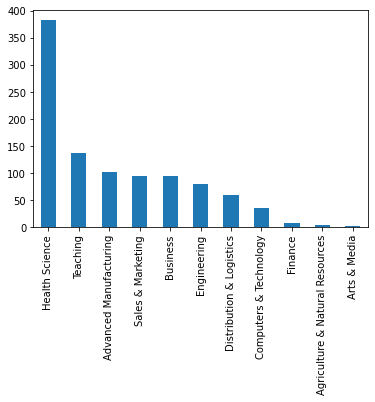

In [5]:
# Pruning to relevant features
pri_df = roster_df[roster_df.fit_rank == 1]
pri_df.aptitude_fit.value_counts().plot.bar()

In [ ]:
pri_df.interest_fit.value_counts().plot.bar()

In [6]:
apt = set(pri_df.aptitude_fit)
print(len(apt), apt)
interest = set(pri_df.interest_fit)
print(len(interest), interest)

11 {'Advanced Manufacturing', 'Agriculture & Natural Resources', 'Health Science', 'Computers & Technology', 'Sales & Marketing', 'Business', 'Arts & Media', 'Engineering', 'Distribution & Logistics', 'Finance', 'Teaching'}
12 {'Advanced Manufacturing', 'Agriculture & Natural Resources', 'Health Science', 'Architecture & Construction', 'Computers & Technology', 'Sales & Marketing', 'Business', 'Arts & Media', 'Engineering', 'Distribution & Logistics', 'Finance', 'Teaching'}


In [7]:
for col in apt:
    pri_df.loc[pri_df.aptitude_fit == col, "apt_" + col] = 1
for col in interest:
    pri_df.loc[pri_df.interest_fit == col, "int_" + col] = 1

pri_df.replace(np.nan,0,inplace=True)


/var/folders/pt/y3bb3b4j7yz3zzczhxc5l9p0vbrddc/T/ipykernel_66692/1747361408.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pri_df.loc[pri_df.aptitude_fit == col, "apt_" + col] = 1
/var/folders/pt/y3bb3b4j7yz3zzczhxc5l9p0vbrddc/T/ipykernel_66692/1747361408.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pri_df.loc[pri_df.aptitude_fit == col, "apt_" + col] = 1
/var/folders/pt/y3bb3b4j7yz3zzczhxc5l9p0vbrddc/T/ipykernel_66692/1747361408.py:2: SettingWithCopyWarning: 
A value is trying to be set on a co

In [8]:
pri_df.head()

,id,organization,last_name,first_name,email,phone,gender,ethnicity,grad_year,aptitude_fit,...,int_Health Science,int_Architecture & Construction,int_Computers & Technology,int_Sales & Marketing,int_Business,int_Arts & Media,int_Engineering,int_Distribution & Logistics,int_Finance,int_Teaching
2,1125260,Blackman Middle School,ADEEB,MAHRAIL,madeeb000@student.rcschools.net,615-602-5846,f,other,2025,Teaching,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,1125261,Blackman Middle School,JOSEPH,DESPOT,jdespot4709@student.rcschools.net,615-670-7429,m,white,2025,Computers & Technology,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1125263,Blackman Middle School,TUCKER,HARLEY,htucker4494@student.rcschools.net,615-904-3860,f,white,2025,Health Science,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
11,1125275,Blackman Middle School,Nelson,Tywon,tnelson2499@student.rcschools.net,222-222-2222,m,black,2025,Advanced Manufacturing,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14,1125314,Blackman Middle School,ALEX,NGUYEN,anguyen9399@student.rcschools.net,615-904-3860,m,asian,2025,Health Science,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
cols = list(pri_df.columns)
cooc_cols = []
for col in cols:
    if ("apt_" in col) or ("int_" in col):
        cooc_cols.append(col)

#cooc_cols 

In [10]:
cooc_pre = pri_df[cooc_cols].astype(int)
coocc = cooc_pre.T.dot(cooc_pre)
np.fill_diagonal(coocc.values, 0)
coocc.head()

,apt_Advanced Manufacturing,apt_Agriculture & Natural Resources,apt_Health Science,apt_Computers & Technology,apt_Sales & Marketing,apt_Business,apt_Arts & Media,apt_Engineering,apt_Distribution & Logistics,apt_Finance,...,int_Health Science,int_Architecture & Construction,int_Computers & Technology,int_Sales & Marketing,int_Business,int_Arts & Media,int_Engineering,int_Distribution & Logistics,int_Finance,int_Teaching
apt_Advanced Manufacturing,0,0,0,0,0,0,0,0,0,0,...,10,2,2,19,5,0,10,11,1,37
apt_Agriculture & Natural Resources,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,2
apt_Health Science,0,0,0,0,0,0,0,0,0,0,...,27,5,8,69,32,1,42,35,0,150
apt_Computers & Technology,0,0,0,0,0,0,0,0,0,0,...,1,1,1,5,3,1,3,4,0,17
apt_Sales & Marketing,0,0,0,0,0,0,0,0,0,0,...,7,0,4,25,5,0,10,9,1,31


In [11]:
apt_cols = []
int_cols = []
for col in cooc_cols:
    if "apt_" in col:
        apt_cols.append(col)
    else:
        int_cols.append(col)

<AxesSubplot:>

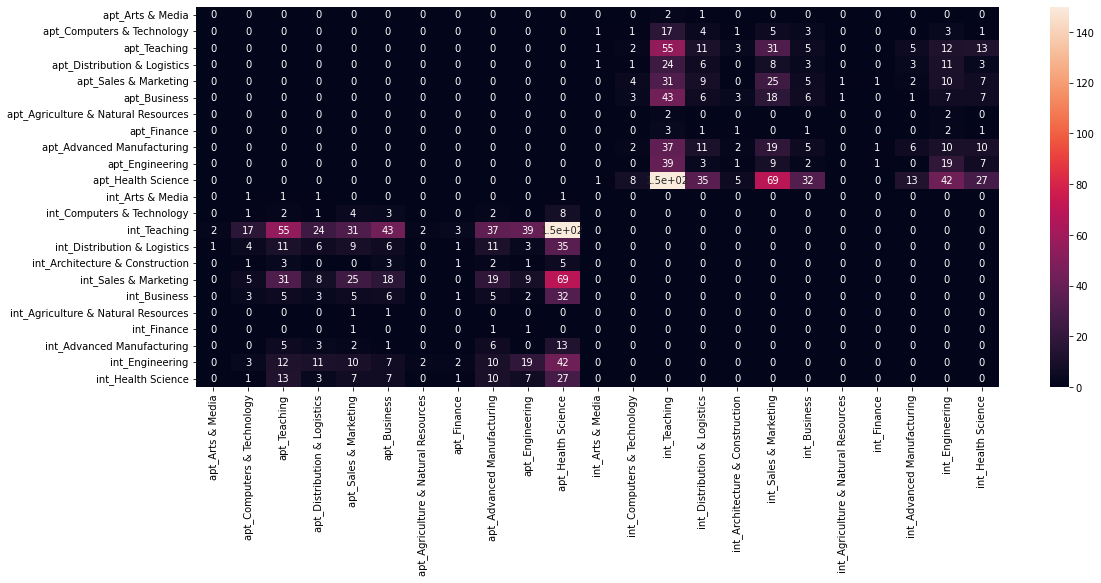

In [25]:
# fig, ax = plt.subplots(figsize=(18,7))
# sns.heatmap(coocc,annot=coocc.values, ax=ax)

In [12]:
# need to determine how aptitude and interests align
demands = coocc[apt_cols]
demands.drop(apt_cols, axis = 0, inplace=True)
demands

/var/folders/pt/y3bb3b4j7yz3zzczhxc5l9p0vbrddc/T/ipykernel_66692/119579065.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demands.drop(apt_cols, axis = 0, inplace=True)


,apt_Advanced Manufacturing,apt_Agriculture & Natural Resources,apt_Health Science,apt_Computers & Technology,apt_Sales & Marketing,apt_Business,apt_Arts & Media,apt_Engineering,apt_Distribution & Logistics,apt_Finance,apt_Teaching
int_Advanced Manufacturing,6,0,13,0,2,1,0,0,3,0,5
int_Agriculture & Natural Resources,0,0,0,0,1,1,0,0,0,0,0
int_Health Science,10,0,27,1,7,7,0,7,3,1,13
int_Architecture & Construction,2,0,5,1,0,3,0,1,0,1,3
int_Computers & Technology,2,0,8,1,4,3,0,0,1,0,2
int_Sales & Marketing,19,0,69,5,25,18,0,9,8,0,31
int_Business,5,0,32,3,5,6,0,2,3,1,5
int_Arts & Media,0,0,1,1,0,0,0,0,1,0,1
int_Engineering,10,2,42,3,10,7,0,19,11,2,12
int_Distribution & Logistics,11,0,35,4,9,6,1,3,6,1,11


<AxesSubplot:>

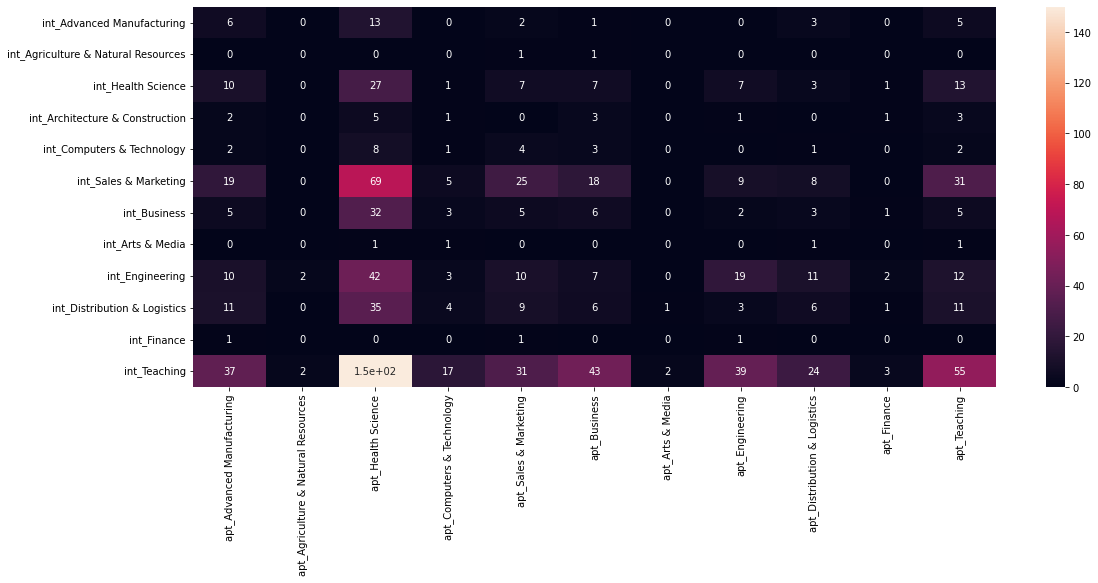

In [13]:
fig, ax = plt.subplots(figsize=(18,7))
sns.heatmap(demands, annot=demands.values, ax=ax)